In [1]:
#import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_curve
from imblearn.over_sampling import ADASYN  # Import ADASYN
from sklearn.metrics import confusion_matrix

In [2]:
# Load the TF-IDF matrix and the target variable
try:
    tfidf_matrix = pd.read_csv('tfidf_matrix.csv')  # Replace with your TF-IDF matrix file name
    print("TF-IDF matrix loaded successfully.")
except FileNotFoundError:
    print("Error: The TF-IDF matrix file was not found.")
    exit()

TF-IDF matrix loaded successfully.


In [3]:
# Convert the DataFrame to a sparse matrix
X_tfidf = tfidf_matrix.values  # Assuming it's a DataFrame



In [4]:
# Load the dataset containing the target variable
try:
    data = pd.read_csv('fake_job_postings.csv')  # Replace with your actual file name
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: The data file was not found.")
    exit()

Data loaded successfully.


In [5]:
# Define the target variable (y)
y = data['fraudulent']

In [6]:
# Step 1: Split the data into training and hold-out test sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42, stratify=y)


In [7]:
# Step 2: Oversample the minority class using ADASYN
adasyn = ADASYN(random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train)


In [17]:
# Step 3: Train a RandomForestClassifier on the resampled data
model = RandomForestClassifier(random_state=42, class_weight='balanced')
model.fit(X_resampled, y_resampled)


RandomForestClassifier(class_weight='balanced', random_state=42)

In [18]:
# Step 4: Get probabilities for the test set
y_probs = model.predict_proba(X_test)[:, 1]

In [19]:
# Step 5: Set the optimal threshold to 0.5400
optimal_threshold = 0.5400
print(f'Using Fixed Optimal Threshold: {optimal_threshold:.4f}')


Using Fixed Optimal Threshold: 0.5400


In [20]:
# Step 6: Make predictions based on the optimal threshold
y_final_pred = (y_probs >= optimal_threshold).astype(int)


In [21]:
# Step 7: Evaluate the model
print(classification_report(y_test, y_final_pred))


              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3403
           1       0.98      0.60      0.74       173

    accuracy                           0.98      3576
   macro avg       0.98      0.80      0.87      3576
weighted avg       0.98      0.98      0.98      3576



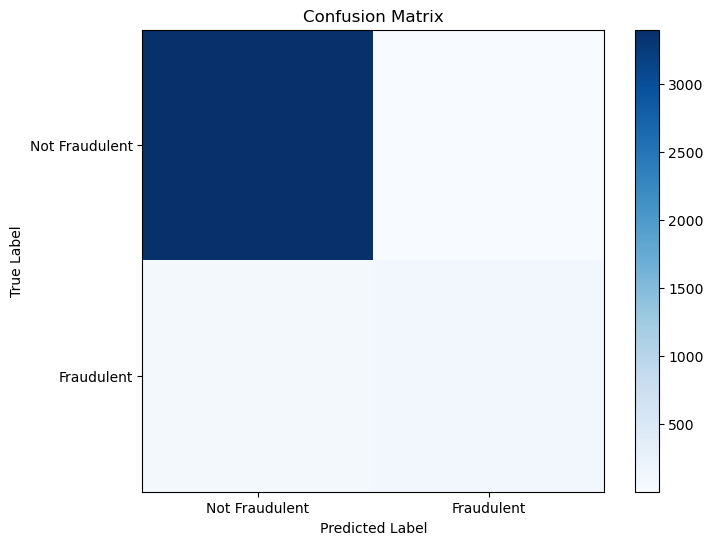

In [24]:
# Step 10: Confusion Matrix
confusion_mat = confusion_matrix(y_test, y_final_pred)
plt.figure(figsize=(8, 6))
plt.imshow(confusion_mat, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Not Fraudulent', 'Fraudulent'])
plt.yticks(tick_marks, ['Not Fraudulent', 'Fraudulent'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()